In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from fastai.vision.all import *
from torchinfo import summary
print(torch.__version__)

2.6.0+cu124


In [3]:
transform = transforms.ToTensor()

# Download and load MNIST training data
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Download and load MNIST test data
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.75MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 11.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.42MB/s]


In [4]:
dls = DataLoader(mnist_train, batch_size=64, shuffle=True)
xb, yb = next(iter(dls))
xb = xb.view(64, -1, 28, 28)
xb.shape, yb.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

<Axes: >

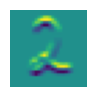

In [5]:
top_edge = torch.tensor([[-1,-1,-1], [0,0,0], [1,1,1]]).float()
bottom_edge = torch.tensor([[1,1,1], [0,0,0], [-1,-1,-1]]).float()
edge_kernels = torch.stack([top_edge, bottom_edge]).unsqueeze(1)
#show_image(xb[59].view(-1, 28))
batch_features = F.conv2d(xb.view(-1, 1, 28, 28), edge_kernels, stride=1, padding=1)
show_image(batch_features[59][0])

In [6]:
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1)
)
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [7]:
def conv(ni, nf, ks=3, act=True):
  res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
  if act: res = nn.Sequential(res, nn.ReLU())
  return res
def conv_with_batchnorm(ni, nf, ks=3, act=True):
  layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
  if act: layers.append(nn.ReLU())
  layers.append(nn.BatchNorm2d(nf))
  return nn.Sequential(*layers)

# THIS IS STANDARD. Do not want to normalize after activations
def conv_with_batchnorm_reversed(ni, nf, ks=3, act=True):
  layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
  layers.append(nn.BatchNorm2d(nf))
  if act: layers.append(nn.ReLU())
  return nn.Sequential(*layers)

In [8]:
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,10, act=False), #1x1
    Flatten(),
)
simple_cnn_v2 = sequential(
    conv_with_batchnorm(1 ,8),            #14x14
    conv_with_batchnorm(8 ,16),            #7x7
    conv_with_batchnorm(16 ,32),           #4x4
    conv_with_batchnorm(32,64),           #2x2
    conv_with_batchnorm(64,10, act=False), #1x1
    Flatten(),
)
simple_cnn_v3 = sequential(
    conv_with_batchnorm_reversed(1 ,8),            #14x14
    conv_with_batchnorm_reversed(8 ,16),            #7x7
    conv_with_batchnorm_reversed(16 ,32),           #4x4
    conv_with_batchnorm_reversed(32,64),           #2x2
    conv_with_batchnorm_reversed(64,10, act=False), #1x1
    Flatten(),
)
simple_cnn(xb).shape
summary(simple_cnn, input_size=(64, 1, 28, 28))#, simple_cnn(xb).shape
summary(simple_cnn_v2, input_size=(64, 1, 28, 28))#, simple_cnn(xb).shape

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 10]                  --
├─Sequential: 1-1                        [64, 8, 14, 14]           --
│    └─Conv2d: 2-1                       [64, 8, 14, 14]           80
│    └─ReLU: 2-2                         [64, 8, 14, 14]           --
│    └─BatchNorm2d: 2-3                  [64, 8, 14, 14]           16
├─Sequential: 1-2                        [64, 16, 7, 7]            --
│    └─Conv2d: 2-4                       [64, 16, 7, 7]            1,168
│    └─ReLU: 2-5                         [64, 16, 7, 7]            --
│    └─BatchNorm2d: 2-6                  [64, 16, 7, 7]            32
├─Sequential: 1-3                        [64, 32, 4, 4]            --
│    └─Conv2d: 2-7                       [64, 32, 4, 4]            4,640
│    └─ReLU: 2-8                         [64, 32, 4, 4]            --
│    └─BatchNorm2d: 2-9                  [64, 32, 4, 4]            64
├─Sequent

In [9]:
def train_model(model, optimizer, epochs=4, device="cpu"):
  model.to(device)
  model.train()
  for epoch in range(epochs):
    train_loss = 0
    correct = 0
    for xb, yb in DataLoader(mnist_train, batch_size=64, shuffle=True):
      optimizer.zero_grad()
      xb = xb.to(device)
      yb = yb.to(device)
      preds = model(xb)
      loss = F.cross_entropy(preds, yb)
      loss.backward()
      optimizer.step()
      correct += (preds.argmax(dim=1) == yb).sum().item()
      train_loss += loss.item() * xb.size(0)
    train_loss /= len(mnist_train)
    train_acc = correct / len(mnist_train)
    print(f"Epoch {epoch+1}: Train loss {train_loss:.4f}, Train accuracy {train_acc:.4f}")



def validate_model(model, epochs = 1, device="cpu"):
  model.to(device)
  model.eval()
  for epoch in range(epochs):
    correct = 0
    val_loss = 0
    with torch.no_grad():
      for xb, yb in DataLoader(mnist_test, batch_size=64, shuffle=True):
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        val_loss += loss.item() * xb.size(0)
        correct += (preds.argmax(dim=1) == yb).sum().item()
    val_acc = correct / len(mnist_test)
    val_loss /= len(mnist_test)
    print(f"Epoch {epoch+1}: Val loss {val_loss:.4f}, Val accuracy {val_acc:.4f}")



def train_and_validate(model, optimizer, epochs=4, device="cpu"):
  model.to(device)
  model.train()
  for epoch in range(epochs):
    train_loss = 0
    train_correct = 0
    for xb, yb in DataLoader(mnist_train, batch_size=64, shuffle=True):
      optimizer.zero_grad()
      xb = xb.to(device)
      yb = yb.to(device)
      preds = model(xb)
      loss = F.cross_entropy(preds, yb)
      loss.backward()
      optimizer.step()
      train_correct += (preds.argmax(dim=1) == yb).sum().item()
      train_loss += loss.item() * xb.size(0)
    train_loss /= len(mnist_train)
    train_acc = train_correct / len(mnist_train)
    #print(f"Epoch {epoch+1}: Train loss {train_loss:.4f}, Train accuracy {train_acc:.4f}")
    val_correct = 0
    val_loss = 0
    with torch.no_grad():
      for xb, yb in DataLoader(mnist_test, batch_size=64, shuffle=True):
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        val_loss += loss.item() * xb.size(0)
        val_correct += (preds.argmax(dim=1) == yb).sum().item()
    val_acc = val_correct / len(mnist_test)
    val_loss /= len(mnist_test)
    print(f"Epoch {epoch+1}: Train loss {train_loss:.4f}, Train accuracy {train_acc:.4f} Val loss {val_loss:.4f}, Val accuracy {val_acc:.4f}")

def train_and_validate_adj_lr(model, optimizer, epochs=4, device="cpu"):
  model.to(device)
  for epoch in range(epochs):
    train_loss = 0
    train_correct = 0
    model.train()
    for xb, yb in DataLoader(mnist_train, batch_size=64, shuffle=True):
      optimizer.zero_grad()
      xb = xb.to(device)
      yb = yb.to(device)
      preds = model(xb)
      loss = F.cross_entropy(preds, yb)
      loss.backward()
      optimizer.step()
      train_correct += (preds.argmax(dim=1) == yb).sum().item()
      train_loss += loss.item() * xb.size(0)
    train_loss /= len(mnist_train)
    train_acc = train_correct / len(mnist_train)
    #print(f"Epoch {epoch+1}: Train loss {train_loss:.4f}, Train accuracy {train_acc:.4f}")
    val_correct = 0
    val_loss = 0

    model.eval()
    with torch.no_grad():
      for xb, yb in DataLoader(mnist_test, batch_size=64, shuffle=True):
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        val_loss += loss.item() * xb.size(0)
        val_correct += (preds.argmax(dim=1) == yb).sum().item()
    val_acc = val_correct / len(mnist_test)
    val_loss /= len(mnist_test)
    print(f"Epoch {epoch+1}: Train loss {train_loss:.4f}, Train accuracy {train_acc:.4f} Val loss {val_loss:.4f}, Val accuracy {val_acc:.4f}")

In [10]:
#train_model(simple_cnn, torch.optim.Adam(simple_cnn.parameters(), lr=0.01), epochs=5, device="cuda")
#validate_model(simple_cnn, epochs=5, device="cuda")
train_and_validate(simple_cnn, torch.optim.Adam(simple_cnn.parameters(), lr=0.01), epochs=5, device="cpu")

Epoch 1: Train loss 0.2705, Train accuracy 0.9165 Val loss 0.1582, Val accuracy 0.9509
Epoch 2: Train loss 0.1237, Train accuracy 0.9618 Val loss 0.1104, Val accuracy 0.9651
Epoch 3: Train loss 0.1078, Train accuracy 0.9672 Val loss 0.1212, Val accuracy 0.9626
Epoch 4: Train loss 0.1021, Train accuracy 0.9688 Val loss 0.1007, Val accuracy 0.9677
Epoch 5: Train loss 0.0937, Train accuracy 0.9711 Val loss 0.0944, Val accuracy 0.9726


In [11]:
train_and_validate(simple_cnn_v2, torch.optim.Adam(simple_cnn_v2.parameters(), lr=0.1), epochs=5, device="cuda")

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
train_and_validate(simple_cnn_v3, torch.optim.Adam(simple_cnn_v3.parameters(), lr=0.1), epochs=5, device="cuda")

Image:


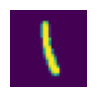

Prediction: 1 
 List of Predictions: tensor([[-15.9500,  10.9699,  -1.9734, -12.9779,  -5.0234,  -8.1025,  -9.1455,
          -6.3812,  -4.5376,  -7.2061]])
torch.Size([1, 1, 28, 28])
Image:


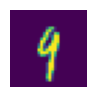

Prediction: 9 
 List of Predictions: tensor([[-11.5649,  -1.5364,  -6.8251,  -8.3353,   2.6755,  -9.0984, -14.0915,
          -0.5124,  -2.2745,   6.2874]])
torch.Size([1, 1, 28, 28])
Image:


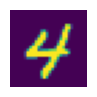

Prediction: 4 
 List of Predictions: tensor([[-11.2141,  -7.4833,  -4.7596, -12.3547,  11.8452, -15.1885,  -8.3299,
          -1.6501,  -5.9288,  -3.2644]])
torch.Size([1, 1, 28, 28])
Image:


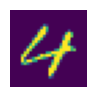

Prediction: 4 
 List of Predictions: tensor([[-14.2838,  -7.6690,  -9.0159, -13.2484,  10.7846, -11.1752,  -2.7107,
           1.8198,  -6.4318,   1.2202]])
torch.Size([1, 1, 28, 28])
Image:


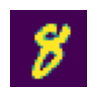

Prediction: 8 
 List of Predictions: tensor([[ -4.2368,  -5.6468,  -3.3359,  -2.2847,  -5.6217,  -6.1196, -11.4231,
         -11.5956,   9.8602,  -2.1952]])
torch.Size([1, 1, 28, 28])


In [26]:
# Test the model with real images
xb, yb = next(iter(dls))
# xb = xb.to("cuda")
num_images = 5
model = simple_cnn;
model.eval();
with torch.no_grad():
  for i in range(num_images):
    print("Image:")
    show_image(xb[i])
    plt.show()
    preds = model(xb[i].unsqueeze(0)) # CNN takes in [batch_size, 1, 28, 28]
    #print(f"Prediction: {preds.argmax()} \n List of Predictions: {preds}")
    if (preds.argmax(1).item() != yb[i].item()):
      print("Wrong prediction")
    print(f"Prediction: {preds.argmax(1).item()} \n List of Predictions: {preds}")
    print(xb[i].unsqueeze(0).shape)

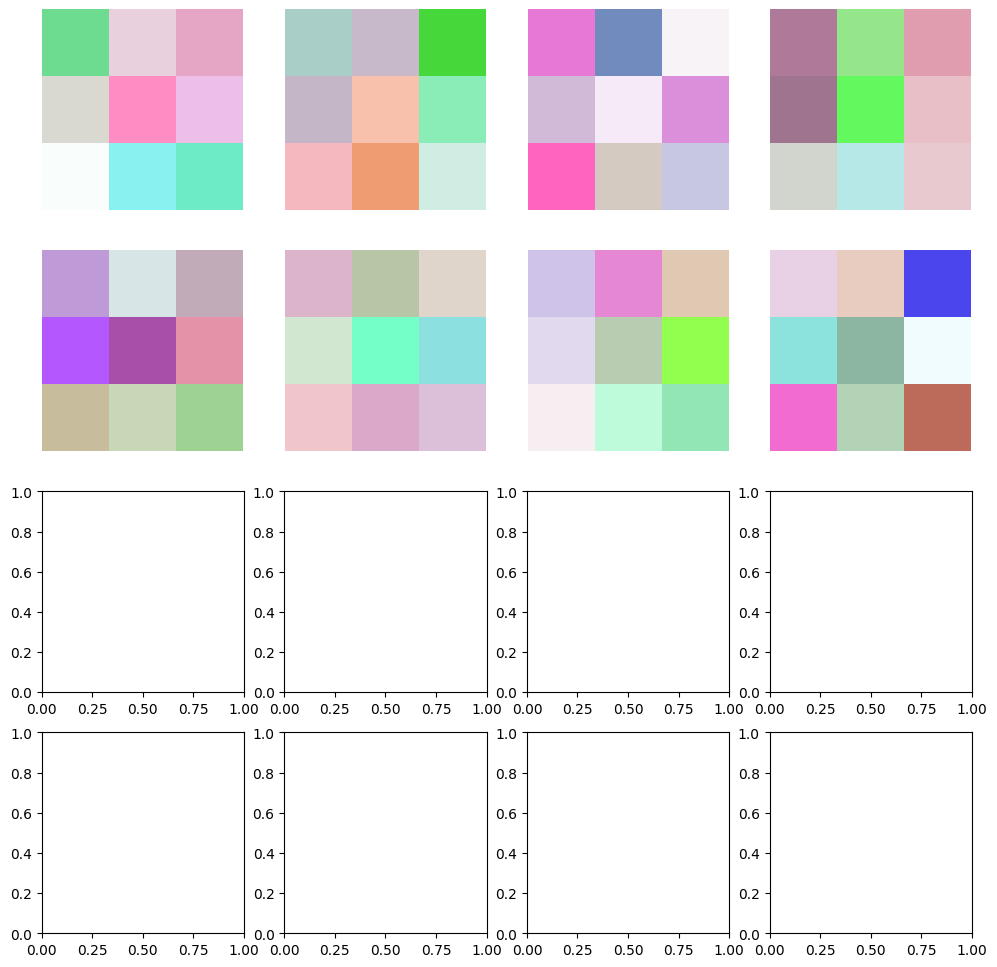

In [75]:
def normalize_0_1(tensor):
    t_min = tensor.min()
    t_max = tensor.max()
    return (tensor - t_min) / (t_max - t_min + 1e-8)  # epsilon avoids div by zero
# for name, param in simple_cnn.named_parameters():
#     print(f"{name}:\n{param.data}\n")
simple_cnn_params = list(simple_cnn.parameters());
len(simple_cnn_params)
layer1_filters = [normalize_0_1(simple_cnn_params[0][i].detach()) for i in range(simple_cnn_params[0].shape[0])]
# show_images(layer1_filters, nrows=2, ncols=3)
# w = simple_cnn_params[0][0][0]
# show_images(w.detach().numpy(), cmap="gray")
layer2_filters = [normalize_0_1(simple_cnn_params[2][i].detach()) for i in range(simple_cnn_params[2].shape[0])]
show_images(layer2_filters, nrows=4, ncols=4)
# show_images(layer2_filters, nrows=2, ncols=3)